# Part 1 Data acquiring and processing


In [ ]:
! pip install yfinance statsmodels sklearn --quiet

In [ ]:
# import packages
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import numpy as np
import pandas as pd

# Reomve all the warinings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
### Acquire stock or index data
# Request historical data for past 10 years 
#SP500 = yf.Ticker("^GSPC").history(period='5y',interval = "1wk")
#Stock US
#stock = yf.Ticker("AMZN").history(period='5y',interval = "1wk")
# Stock China SZ or SS, 000300 is CSI300
stock = yf.Ticker("000300.SS").history(period='5y',interval = "1wk")
# reset data index
stock.reset_index(inplace=True)

In [ ]:
# Only date and close are needed and calculate the returns
stock = stock[['Date','Close']]
stock['returns'] = (stock['Close'] - stock['Close'].shift(1))/(stock['Close'].shift(1))
stock = stock.dropna(axis=0,how='any')
stock = stock.reset_index(drop=True)


# Part 2 Preliminary analysis

<AxesSubplot:xlabel='Date'>

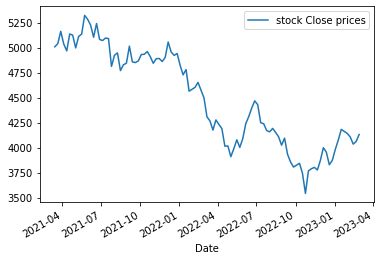

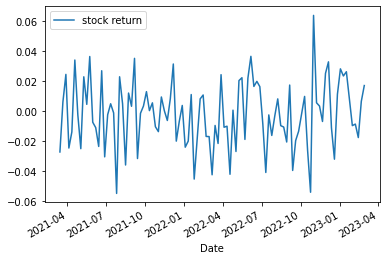

In [ ]:
### Price plotting 
stock.plot(x='Date', y = 'Close', kind='line',label='stock Close prices')
### Returns plotting
stock.plot(x='Date', y = 'returns', kind='line',label='stock return')

In [ ]:
# Stock data displaying
print(stock)

                        Date        Close   returns
0  2021-03-15 00:00:00+08:00  5007.089844 -0.027066
1  2021-03-22 00:00:00+08:00  5037.990234  0.006171
2  2021-03-29 00:00:00+08:00  5161.560059  0.024528
3  2021-04-05 00:00:00+08:00  5035.339844 -0.024454
4  2021-04-12 00:00:00+08:00  4966.180176 -0.013735
..                       ...          ...       ...
95 2023-01-30 00:00:00+08:00  4141.629883 -0.009542
96 2023-02-06 00:00:00+08:00  4106.310059 -0.008528
97 2023-02-13 00:00:00+08:00  4034.510010 -0.017485
98 2023-02-20 00:00:00+08:00  4061.050049  0.006578
99 2023-02-27 00:00:00+08:00  4130.551270  0.017114

[100 rows x 3 columns]


#Part 3 Regime Shift Analysis


In [ ]:
# Check stationarity of the data
adfuller(stock['Close'])

(-1.1429195226545732,
 0.6976563035168715,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 1044.123152830895)

In [ ]:
#the p value is 0.48074, which fails to reject the null hypothesis, we can say the data is non-stationary. 

In [ ]:
#Check all the rows in dataframe
#pd.set_option('display.max_rows', None)
### Assign the endog data
endog = stock['returns'].iloc[1:]
endog.dropna(inplace=True)
endog = endog.reset_index(drop=True)

In [ ]:
# Assign the endog data for plotting analysis
endog_return = stock['returns'].iloc[1:]

In [ ]:
# Assign the exog data
exog = stock['returns'].iloc[:-1]
exog.dropna(inplace=True)
exog = exog.reset_index(drop=True)

In [ ]:
### Copy the 2 dataasets for the variance calculation
endog2 = endog.copy()
exog2 = exog.copy()

In [ ]:
# 2 regimes for the return, which basicly is up or down for a stock. 
# trend =c means there will be an constant
mod_kns = sm.tsa.MarkovRegression(endog, k_regimes=2,trend='c',exog=exog)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                   99
Model:               MarkovRegression   Log Likelihood                 238.093
Date:                Sat, 04 Mar 2023   AIC                           -462.185
Time:                        06:11:51   BIC                           -444.019
Sample:                             0   HQIC                          -454.835
                                 - 99                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.004     -0.767      0.443      -0.011       0.005
x1             0.1745      0.165      1.059      0.290      -0.149       0.498
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.361      0.718      -0.008       0.006
x1            -0.2829      0.142     -1.991      0.047      -0.562      -0.004
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   6.75e-05      6.852      0.000       0.000       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     1.431e-07        nan        nan        nan         nan         nan
p[1->0]        0.9543      0.070     13.710      0.000       0.818       1.091
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [ ]:
# Check the model paramters
res_kns.params

p[0->0]     1.430992e-07
p[1->0]     9.542941e-01
const[0]   -3.103320e-03
const[1]   -1.266652e-03
x1[0]       1.745317e-01
x1[1]      -2.829495e-01
sigma2      4.625341e-04
dtype: float64

In [ ]:
# Assign the last return value as the current value
current_return= endog.iat[-1]

In [ ]:
### Predict for tomorrow.
# Assign model parameters
p00 = res_kns.params[0]
p01 = 1-p00
p10 = res_kns.params[1]
p11 = 1-p10
const0 = res_kns.params[2]
const1 = res_kns.params[3]
x0 = res_kns.params[4]
x1 = res_kns.params[5]
### Y(t) = const+x1*Y(t-1), the noise has been ignored since it follows a normal distribution with a very low variance. 
Predict_return_Regime0 = const0 + x0*current_return
Predict_return_Regime1 = const1 + x1*current_return
#### Check for tomorrow with 2 regimes' added probability
Predict_return = Predict_return_Regime0 *(p00+p10) +Predict_return_Regime1*(p10+p11)

In [ ]:
#Get the predicted return for tomorrow
print(Predict_return)

-0.00622012552729457


# RMSE analysis

In [ ]:
# Assign the 80% of the total data as  train data
N_train = int(len(stock)*0.8)

In [ ]:
# Print the train data to check 
stock['returns'].iloc[1:N_train]

1     0.006171
2     0.024528
3    -0.024454
4    -0.013735
5     0.034085
        ...   
75   -0.020435
76    0.017442
77   -0.039355
78   -0.019493
79   -0.013260
Name: returns, Length: 79, dtype: float64

In [ ]:
#Use the train data to do the prediction and store the data into a list for RMSE analysis
Predicted_return_list=[] 
for i in range(N_train,len(stock)):
  stock_R = stock[:i]
  ### endog
  endog_R = stock_R['returns'].iloc[1:]
  endog_R.dropna(inplace=True)
  endog_R = endog_R.reset_index(drop=True)

  # exog
  exog_R = stock_R['returns'].iloc[:-1]
  exog_R.dropna(inplace=True)
  exog_R = exog_R.reset_index(drop=True)

  # Model fitting
  # 2 regimes for the return, which basicly is up or down for a stock. 
  mod_kns = sm.tsa.MarkovRegression(endog_R, k_regimes=2,trend='c',exog=exog_R)
  res_kns = mod_kns.fit()
  res_kns.summary()

  #Current value 
  current_return_R= endog_R.iat[-1]

  ### Predict for tomorrow.
  p00 = res_kns.params[0]
  p01 = 1-p00
  p10 = res_kns.params[1]
  p11 = 1-p10
  const0 = res_kns.params[2]
  const1 = res_kns.params[3]
  x0 = res_kns.params[4]
  x1 = res_kns.params[5]
  ### Y(t) = const+x1*Y(t-1), the noise has been ignored since it follows a normal distribution with low variance. 
  Predict_return_Regime0 = const0 + x0*current_return_R
  Predict_return_Regime1 = const1 + x1*current_return_R
  #### Check for tomorrow adding probability

  Predict_return_R = Predict_return_Regime0 *(p00+p10) +Predict_return_Regime1*(p10+p11)
  # The predicted values
  Predicted_return_list.append(Predict_return_R)

In [ ]:
# The real return of the stock
real_return = stock['returns'].iloc[N_train:].values.tolist()

In [ ]:
#Calculate the RMSE between the predicted values and the real values 
mean_squared_error(real_return, Predicted_return_list)

0.0011397016524296647

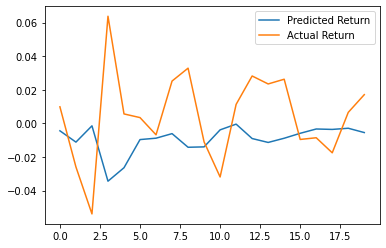

In [ ]:
### Price plotting 
plt.plot(Predicted_return_list,label="Predicted Return")
plt.plot(real_return,label="Actual Return")
plt.legend(loc="upper right")
#plt.title('Predicted return (Blue) and actual return (Yellow)')
plt.show()

In [ ]:
# Normalize Close data to better visulize the relationship between close and regimes
endog1 =endog.copy() 
normalized_close = preprocessing.normalize([endog1])
normalized_close = pd.DataFrame(normalized_close)
normalized_close = normalized_close.T
print(normalized_close)

           0
0   0.027858
1   0.110719
2  -0.110386
3  -0.062000
4   0.153860
..       ...
94 -0.043073
95 -0.038496
96 -0.078930
97  0.029695
98  0.077254

[99 rows x 1 columns]


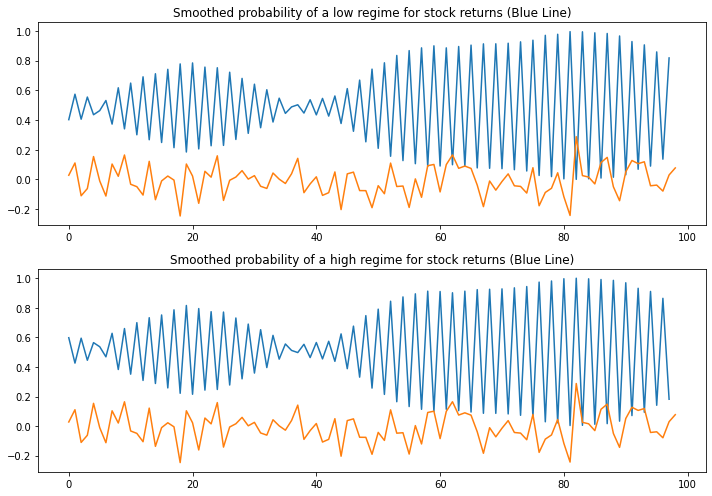

In [ ]:
#plotting smoothed probabilities of the regimes:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
# Compare with the the return 
ax.plot(normalized_close)
#ax.plot(endog_return)
ax.set(title='Smoothed probability of a low regime for stock returns (Blue Line)')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
### The constant for 1 is higher
ax.set(title='Smoothed probability of a high regime for stock returns (Blue Line)')
ax.plot(normalized_close)
#ax.plot(endog_return)
# The below section can be used when there is a third regime
#ax = axes[2]
# ax.plot(res_kns.smoothed_marginal_probabilities[2])
# ax.set(title='Smoothed probability of a low regime for stock returns')
# ax.plot(endog_return)
fig.tight_layout()

In [ ]:
# The durations of 2 regimes
print(res_kns.expected_durations)

[1.00000003 1.04713352]


### Variance

In [ ]:
# 3 regimes can be used to detect the variance
mod_kns = sm.tsa.MarkovRegression(endog2, k_regimes=3, exog=exog2, trend='c', switching_variance=True)
res_kns = mod_kns.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                   99
Model:               MarkovRegression   Log Likelihood                 241.727
Date:                Sat, 04 Mar 2023   AIC                           -453.453
Time:                        06:12:09   BIC                           -414.526
Sample:                             0   HQIC                          -437.703
                                 - 99                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.004      5.890      0.000       0.014       0.029
x1             0.1527      0.138      1.110      0.267      -0.117       0.422
sigma2      6.243e-05   3.68e-05      1.696      0.090   -9.72e-06       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0152        nan        nan        nan         nan         nan
x1             0.2101      0.163      1.291      0.197      -0.109       0.529
sigma2         0.0004      0.000      2.813      0.005       0.000       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.005     -0.334      0.739      -0.011       0.008
x1            -0.3202      0.054     -5.927      0.000      -0.426      -0.214
sigma2         0.0003   9.17e-05      3.473      0.001       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5086      0.215      2.363      0.018       0.087       0.931
p[1->0]        0.1884      0.220      0.856      0.392      -0.243       0.620
p[2->0]        0.0309      0.106      0.292      0.771      -0.177       0.239
p[0->1]     1.078e-07        nan        nan        nan         nan         nan
p[1->1]        0.0004        nan        nan        nan         nan         nan
p[2->1]        0.6878        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

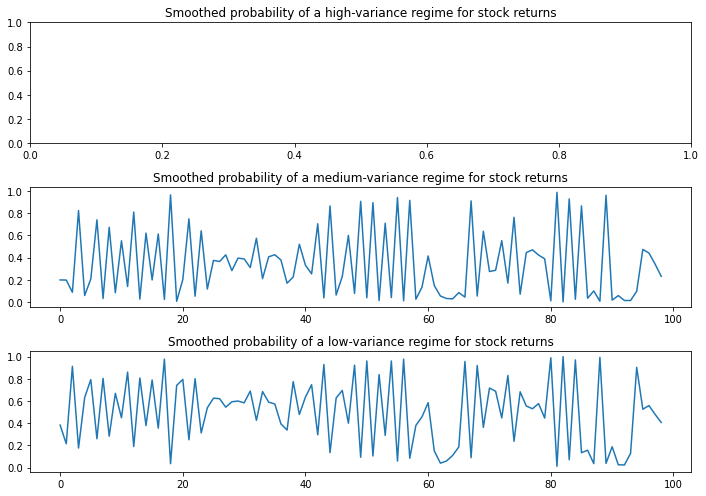

In [ ]:
#plotting smoothed probabilities of the regimes for variances:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
#ax.plot(endog_return)
ax.set(title='Smoothed probability of a high-variance regime for stock returns')
ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a medium-variance regime for stock returns')
#ax.plot(endog_return)
ax = axes[2]
ax.plot(res_kns.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of a low-variance regime for stock returns')
# ax.plot(endog_return)
fig.tight_layout()

In [ ]:
# THe time duration for 3 variances regimes
print(res_kns.expected_durations)

[2.03510268 1.00037638 1.39135328]
